In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = 'CMSC828C/Project 2/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))
%cd /content/drive/My\ Drive/$FOLDERNAME
!pip3 install -U libsvm-official

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/CMSC828C/Project 2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np
import matplotlib.pyplot as plt
from libsvm.svmutil import *
from Codes.classifiers.utils import flatten, PCA_proj, MDA

USE_GPU = False
dtype = torch.float32 # We will be using float throughout this tutorial.

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss.
print_every = 100
print('using device:', device)

using device: cpu


In [ ]:
# parameters
NUM_TRAIN = 60000
NUM_TEST = 10000
LEARNING_RATE = 1e-3
BATCH_SIZE_TRAIN = 10000
BATCH_SIZE_TEST = 10000
N_EPOCHS = 15

N_CLASSES = 10

In [ ]:
# The torchvision.transforms package provides tools for preprocessing data
# and for performing data augmentation; here we set up a transform to
# preprocess the data by subtracting the mean RGB value and dividing by the
# standard deviation of each RGB value; we've hardcoded the mean and std.
# define transforms
transform = T.Compose([T.Resize((28, 28)),
                        T.ToTensor()])

mnist_train = dset.MNIST('./Datasets', train=True, download=True,
                             transform=transform)
loader_train = DataLoader(mnist_train, batch_size=NUM_TRAIN)

mnist_test = dset.MNIST('./Datasets', train=False, download=True, 
                            transform=transform)
loader_test = DataLoader(mnist_test,  batch_size=NUM_TEST)

In [ ]:
X_train = loader_train.dataset.data.cpu().detach().numpy()
y_train = loader_train.dataset.targets.cpu().detach().numpy()
X_test = loader_test.dataset.data.cpu().detach().numpy()
y_test = loader_test.dataset.targets.cpu().detach().numpy()

X_train = flatten(X_train)
X_test = flatten(X_test)

X_train = X_train[:BATCH_SIZE_TRAIN, :]
y_train = y_train[:BATCH_SIZE_TRAIN]

X_test = X_test[:BATCH_SIZE_TEST, :]
y_test = y_test[:BATCH_SIZE_TEST]
print(X_train.shape)
X_train_PCA, V_train = PCA_proj(X_train)
X_test_PCA = np.real(np.matmul(X_test, V_train))
print(X_train_PCA.shape)
print(y_train.shape)
print(X_test_PCA.shape)
print(y_test.shape)

(10000, 784)
---------------- PCA --------------------
10000 784
Data Centering.....
Data Centered
Covariance calculated
Eigvals and Eigvecs calculated
Required Dimension:  327
Got new clipped projection matrix
X_train projected
(10000, 327)
(10000,)
(10000, 327)
(10000,)


In [ ]:
X_train_MDA, Theta = MDA(X_train, y_train, N_CLASSES)
X_test_MDA = np.real(np.matmul(X_test, Theta))
print(X_train_MDA.shape)
print(y_train.shape)
print(X_test_MDA.shape)
print(y_test.shape)

Theta shape:  (784, 9)
------------ MDA -------------
(10000, 9)
(10000,)
(10000, 9)
(10000,)


In [ ]:
# ------------------------ SVM -----------------------------
def train(p, x, y):
    prob = svm_problem(y, x)
    m = svm_train(prob, p)
    return m

def predict(model, x,y):
    p_label, p_acc, p_val = svm_predict(y, x, model)
    return p_acc



def SVM(X_train,  y_train, X_test, y_test):
  choice = int(input('Enter the choice of kernel 1:linear 2:polynomial 3:RBF'))
  accuracies = []
  if choice == 1:
      param = svm_parameter('-q -t 0')
      model = train(param, X_train, y_train)
      predict(model, X_test, y_test)

  elif choice == 2:
      degree = [' -d 2', ' -d 3', ' -d 5']
      for i in degree:
          param = svm_parameter('-q -t 1' + i)
          model = train(param, X_train, y_train)
          acc = predict(model, X_test, y_test)
          accuracies.append(acc[0])
      plt.plot(degree, accuracies)
      plt.show()
      
          
  else:
      gamma = [' -g 0.001', ' -g 10', ' -g 1000']
      for i in gamma:
          param = svm_parameter('-q -t 2' + i)
          model = train(param, X_train, y_train)
          acc = predict(model, X_test, y_test)
          accuracies.append(acc[0])
      print(accuracies)
      plt.plot(gamma, accuracies)
      plt.show()
      

# SVM on data projected using PCA

In [ ]:
print('------------ LINEAR KERNEL ---------------')
SVM(X_train_PCA, y_train, X_test_PCA, y_test)

------------ LINEAR KERNEL ---------------
Enter the choice of kernel 1:linear 2:polynomial 3:RBF1
Accuracy = 66.22% (6622/10000) (classification)


------------ POLYNOMIAL KERNEL ---------------
Enter the choice of kernel 1:linear 2:polynomial 3:RBF2
Accuracy = 49.35% (4935/10000) (classification)
Accuracy = 71.28% (7128/10000) (classification)
Accuracy = 68.54% (6854/10000) (classification)


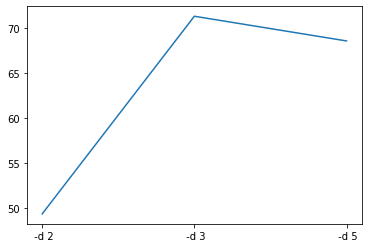

<Figure size 432x288 with 0 Axes>

In [ ]:
print('------------ POLYNOMIAL KERNEL ---------------')
SVM(X_train_PCA, y_train, X_test_PCA, y_test)

------------ RBF KERNEL ---------------
Enter the choice of kernel 1:linear 2:polynomial 3:RBF3
Accuracy = 11.35% (1135/10000) (classification)
Accuracy = 11.35% (1135/10000) (classification)
Accuracy = 11.35% (1135/10000) (classification)
[11.35, 11.35, 11.35]


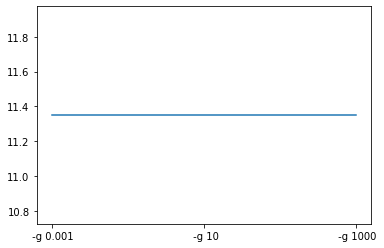

<Figure size 432x288 with 0 Axes>

In [ ]:
print('------------ RBF KERNEL ---------------')
SVM(X_train_PCA, y_train, X_test_PCA, y_test)

# SVM on data projected using MDA

In [ ]:
print('------------ LINEAR KERNEL ---------------')
SVM(X_train_MDA, y_train, X_test_MDA, y_test)

------------ LINEAR KERNEL ---------------
Enter the choice of kernel 1:linear 2:polynomial 3:RBF1
Accuracy = 11.39% (1139/10000) (classification)


------------ POLYNOMIAL KERNEL ---------------
Enter the choice of kernel 1:linear 2:polynomial 3:RBF2
Accuracy = 11.35% (1135/10000) (classification)
Accuracy = 11.35% (1135/10000) (classification)
Accuracy = 11.35% (1135/10000) (classification)


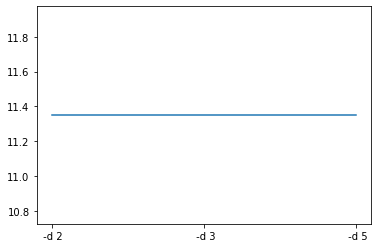

<Figure size 432x288 with 0 Axes>

In [ ]:
print('------------ POLYNOMIAL KERNEL ---------------')
SVM(X_train_MDA, y_train, X_test_MDA, y_test)

------------ RBF KERNEL ---------------
Enter the choice of kernel 1:linear 2:polynomial 3:RBF3
Accuracy = 11.35% (1135/10000) (classification)
Accuracy = 84.8% (8480/10000) (classification)
Accuracy = 87.83% (8783/10000) (classification)
[11.35, 84.8, 87.83]


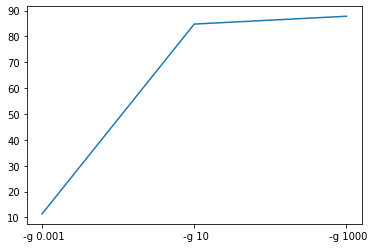

<Figure size 432x288 with 0 Axes>

In [ ]:
print('------------ RBF KERNEL ---------------')
SVM(X_train_MDA, y_train, X_test_MDA, y_test)